In [1]:
import torch
import torchvision.transforms
from tinycss2 import tokenizer
from torch.nn import NLLLoss
from torch.optim import Adam
from torch.utils.data import DataLoader, random_split
import os
import pickle
from PIL import Image
from torchvision import transforms
from torch.nn import functional as F
from torch import nn
from typing import List
from torchmetrics.text import CharErrorRate

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [2]:
from custom_dataset import DecoderDataset
from encoder import Encoder
from Decoder import LSTMAttnDecoder

with open('char_to_token.pkl', 'rb') as f:
    token_dict = pickle.load(f)

In [3]:
with open("token_to_char.pkl", "rb") as f:
    token_to_char = pickle.load(f)

def tokenizer_func(input_list: List[torch.tensor], token: List[str]) -> List[str]:
    return [token[index.item()] for index in input_list]

In [4]:
torch.manual_seed(0)
encoder = Encoder().to(device)
decoder = LSTMAttnDecoder(256, len(token_to_char)).to(device)
# encoder.load_state_dict(torch.load('encoder.pt'))
# for param in encoder.parameters():
#     param.requires_grad = False

In [5]:
torch.manual_seed(0)
padilla_dataset = DecoderDataset('Padilla/labeled_dataset.csv', 'Padilla/cropped_images', token_dict)
# rodrigo_dataset = DecoderDataset('Rodrigo/rodrigo_dataset.csv', 'Rodrigo/images', token_dict)
generated_dataset = DecoderDataset('generated_dataset_for_decoder/train.csv', 'generated_dataset_for_decoder/train', token_dict)
decoder_dataset = torch.utils.data.ConcatDataset([padilla_dataset, generated_dataset])
# decoder_dataset = padilla_dataset
train_size = int(0.9 * len(decoder_dataset))
val_size = len(decoder_dataset) - train_size
train_dataset, val_dataset = random_split(decoder_dataset, [train_size, val_size])
train_dataloader = DataLoader(train_dataset, batch_size=16, shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=16, shuffle=False)

In [6]:
criterion = NLLLoss()
optimizer = Adam(list(encoder.parameters()) + list(decoder.parameters()))
cer = CharErrorRate()

In [7]:
epochs = 20
SOS_token = token_dict['<SOS>']
train_cer_list = []
val_cer_list = []

for epoch in range(epochs):
    # Training loop
    decoder.train()
    total_cer = 0
    batch_count = 0
    for i, (imgs, labels) in enumerate(train_dataloader):
        imgs, labels = imgs.to(device), labels.to(device)

        encoder_outputs, decoder_hidden = encoder(imgs)  # Encoder's forward pass
        decoder_input = torch.tensor([[SOS_token]] * labels.size(0)).to(device)  # SOS token

        loss = 0
        predictions = []
        for t in range(labels.size(1)):
            decoder_output, decoder_hidden = decoder(decoder_input, decoder_hidden, encoder_outputs)
            _, decoder_output_labels = torch.max(decoder_output, dim=1)

            loss += criterion(decoder_output, labels[:, t])
            predictions.append(decoder_output_labels.unsqueeze(0))

            decoder_input = labels[:, t].unsqueeze(1)  # Teacher forcing

        # Transpose the prediction to match labels, calculate and accumulate CER
        predictions = torch.cat(predictions).transpose(0, 1)
        total_cer += sum(cer(tokenizer_func(pred.view(-1), token_to_char), tokenizer_func(label.view(-1), token_to_char)) for pred, label in
                         zip(predictions, labels)) / len(predictions)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        batch_count += 1

        if i % 100 == 0:
            print(
                f"Epoch {epoch + 1}/{epochs}, Batch {i}/{len(train_dataloader)}, Loss: {loss.item()}, CER: {total_cer / batch_count}")
            train_cer_list.append(total_cer / batch_count)

    # Validation loop
    decoder.eval()
    with torch.no_grad():  # Disable gradient calculation
        total_val_loss = 0
        total_val_cer = 0
        val_batch_count = 0
        for i, (imgs, labels) in enumerate(val_dataloader):
            imgs, labels = imgs.to(device), labels.to(device)
            encoder_outputs, decoder_hidden = encoder(imgs)
            decoder_input = torch.tensor([[SOS_token]] * labels.size(0)).to(device)

            loss = 0
            val_predictions = []
            for t in range(labels.size(1)):
                decoder_output, decoder_hidden = decoder(decoder_input, decoder_hidden, encoder_outputs)
                _, decoder_output_labels = torch.max(decoder_output, dim=1)

                loss += criterion(decoder_output, labels[:, t])
                val_predictions.append(decoder_output_labels.unsqueeze(0))

                decoder_input = labels[:, t].unsqueeze(1)  # Teacher forcing

            total_val_loss += loss.item()
            # Transpose and calculate CER
            val_predictions = torch.cat(val_predictions).transpose(0, 1)
            total_val_cer += sum(cer(tokenizer_func(pred.view(-1), token_to_char), tokenizer_func(label.view(-1), token_to_char)) for pred, label in
                                 zip(val_predictions, labels)) / len(val_predictions)
            val_batch_count += 1

        val_loss = total_val_loss / val_batch_count
        val_cer = total_val_cer / val_batch_count
        val_cer_list.append(val_cer)

    print(f"Epoch {epoch + 1}/{epochs}, Validation Loss: {val_loss}, Validation CER: {val_cer}")

Epoch 1/20, Batch 0/630, Loss: 199.69480895996094, CER: 0.9970713257789612
Epoch 1/20, Batch 100/630, Loss: 47.637939453125, CER: 0.17965790629386902
Epoch 1/20, Batch 200/630, Loss: 55.42386245727539, CER: 0.1530524045228958
Epoch 1/20, Batch 300/630, Loss: 33.42878341674805, CER: 0.14196830987930298
Epoch 1/20, Batch 400/630, Loss: 37.28418731689453, CER: 0.1353614628314972
Epoch 1/20, Batch 500/630, Loss: 42.22160339355469, CER: 0.1310240924358368
Epoch 1/20, Batch 600/630, Loss: 37.93232727050781, CER: 0.12809118628501892
Epoch 1/20, Validation Loss: 39.70796707698277, Validation CER: 0.11125656962394714
Epoch 2/20, Batch 0/630, Loss: 39.03986358642578, CER: 0.10484104603528976
Epoch 2/20, Batch 100/630, Loss: 41.740257263183594, CER: 0.1130533516407013
Epoch 2/20, Batch 200/630, Loss: 34.56079864501953, CER: 0.10931260138750076
Epoch 2/20, Batch 300/630, Loss: 34.193702697753906, CER: 0.10717469453811646
Epoch 2/20, Batch 400/630, Loss: 35.46643829345703, CER: 0.10505583882331848


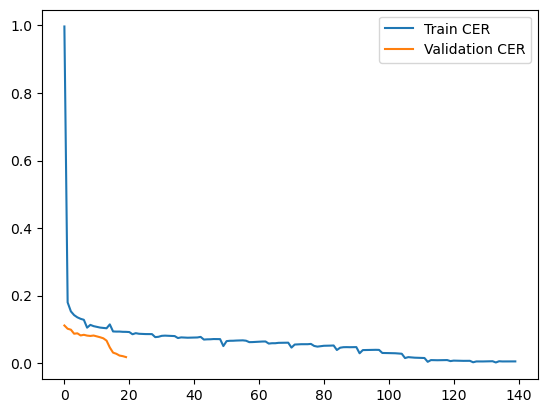

In [8]:
from matplotlib import pyplot as plt

plt.plot(train_cer_list, label='Train CER')
plt.plot(val_cer_list, label='Validation CER')
plt.legend()
plt.show()

In [9]:
torch.save(decoder.state_dict(), "decoder.pt")
torch.save(encoder.state_dict(), "fine_tuned_encoder.pt")

In [10]:
import pickle
import torch
from encoder import Encoder
from Decoder import LSTMAttnDecoder
from torch.utils.data import DataLoader
import os
from torchvision import transforms
from torchvision.transforms import Resize, ToTensor, Lambda
from custom_dataset import resize_and_pad

with open("token_to_char.pkl", "rb") as f:
    token_to_char = pickle.load(f)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
encoder = Encoder().to(device)
decoder = LSTMAttnDecoder(256, len(token_to_char)).to(device)
encoder.load_state_dict(torch.load('fine_tuned_encoder.pt'))
decoder.load_state_dict(torch.load('decoder.pt'))

<All keys matched successfully>

In [12]:
with open('char_to_token.pkl', 'rb') as f:
    token_dict = pickle.load(f)

SOS_token = token_dict['<SOS>']
test_dataset_folder = "generated_dataset_for_decoder/train"

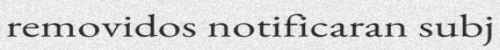

['r', 'e', 'm', 'o', 's', 'c', 'u', 'p', 'i', 's', ' ', 's', 'u', 's', 'u', 'i', 's', 't', 'i', 's', 't', 'e', 'n', ' ', 'a', 'g', 'o', 't', 'i', 't', 'a', 'r', '<EOS>']


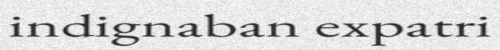

['i', 'n', 'o', 'c', 'u', 'l', 'b', 'a', 'm', 'o', 's', ' ', 'e', 'x', 'p', 'a', 't', 'r', 'i', 'a', 's', ' ', 'e', 'x', 'p', 'a', 't', 'r', 'i', '<EOS>']


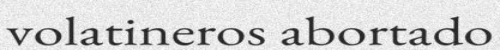

['v', 'e', 'o', 'f', 'r', 'a', 'r', 'i', 's', ' ', 'a', 'f', 'i', 'a', 'n', 'z', 'a', 'r', 'a', 's', ' ', 'a', 'f', 'o', 'r', 'm', 'i', 'z', 'a', 's', 't', 'e', 'i', 's', '<EOS>']


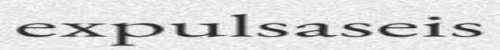

['e', 's', 'q', 'u', 'i', 'v', 'a', 'r', 'i', 's', ' ', 's', 'e', 'c', 'c', 'i', 'o', 'n', 'e', 's', '<EOS>']


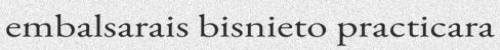

['e', 'n', 'm', 'i', 's', 't', 'i', 'e', 'n', 'd', 'o', ' ', 'i', 'n', 't', 'u', 's', 't', 'i', 'n', 'o', ' ', 's', 'a', 'n', 't', 'i', 'n', 'o', 't', 'i', 'n', 'a', 'r', '<EOS>']


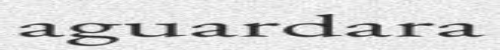

['a', 'g', 'o', 'n', 'a', 'r', 'a', 'n', ' ', 'e', 'n', 'g', 'o', 'r', 'r', 'a', 'r', 'a', '<EOS>']


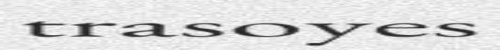

['i', 'r', ' ', 'r', 'e', 'p', 'r', 'o', 'n', 'a', ' ', 'c', 'o', 's', 'e', 'y', 's', ' ', 'o', 's', ' ', 'o', '-', '<EOS>']


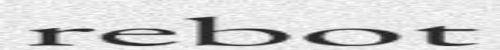

['r', 'e', 'e', 'l', 'i', 'g', 'i', 'o', 's', ' ', 'e', 'x', 't', 'e', '<EOS>']


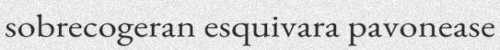

['s', 'i', 'l', 'l', 'a', 's', ' ', 'v', 'e', 'o', 's', ' ', 'r', 'e', 'c', 'o', 'g', 'i', 'a', ',', ' ', 'y', ' ', 'r', 'o', 's', 't', 'a', 'r', 'a', ' ', 'p', 'r', 'o', '-', '<EOS>']


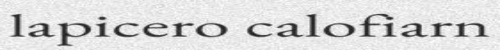

['l', 'a', 'p', 'i', 'c', 'e', 'e', 'n', ' ', 'o', 'c', 'a', 's', 'i', 'o', 'n', 'a', 'r', 'i', 'a', 's', '<EOS>']


In [13]:
import PIL
from PIL import Image
from matplotlib import pyplot as plt
from torchvision.transforms import ToPILImage

import random

img_size = (50, 500)

data_transform = transforms.Compose([
            # Lambda(lambda img: img.convert("L")),  # Convert image to grayscale
            # Lambda(lambda img: img.point(lambda p: p > 128 and 255)),  # Binarize the image
            # Lambda(lambda img: resize_and_pad(img=img, target_size=img_size)),
            Lambda(lambda img: img.convert("RGB")),
            Resize(img_size),
            ToTensor(),  # Convert image to PyTorch Tensor in CHW format
        ])

decoder.eval()

test_data_files = os.listdir(test_dataset_folder)
random.shuffle(test_data_files)

with torch.no_grad():
    for filename in test_data_files[:10]:
        image = Image.open(os.path.join(test_dataset_folder, filename))
        image = data_transform(image)
        display(ToPILImage()(image))
        image_tensor = image.unsqueeze(0).to(device)
        encoder_outputs, decoder_hidden = encoder(image_tensor)
        decoder_input = torch.tensor([[SOS_token]] * image_tensor.size(0)).to(device)
        prediction = []
        for t in range(50):  # Assuming maximum sequence length is 50
            decoder_output, decoder_hidden = decoder(decoder_input, decoder_hidden, encoder_outputs)
            _, topi = decoder_output.topk(1)
            decoder_input = topi.detach()
            prediction.append(decoder_input.item())
            if decoder_input.item() == token_dict['<EOS>']:
                break
        print([token_to_char[i] for i in prediction])